In [1]:
import os
import sys
sys.path.append('/mnt/mnt/5TB_slot2/Tobias')
sys.path.append('/mnt/mnt/5TB_slot2/Tobias/TobiasPy/fastMRI')
sys.path.append('/mnt/mnt/4TB_pcie/fastBrain/')
import h5py
import numpy as np
import numpy.fft as nf
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from models.unet.unet_model import UnetModel as UnetModel
import argparse
from common.args import Args
import models.unet.run_unet  as Run
import torch.nn as nn
import logging
import pathlib
import random
import h5py
from torch.utils.data import Dataset
import time
from torch.nn import functional as F
import shutil
from tensorboardX import SummaryWriter
import torchvision
from torchvision import transforms, utils

import sigpy as sp
import sigpy.plot as pl
import vd_spiral

from wrap_net import wrap_net

%load_ext autoreload
%autoreload 2

In [2]:
sys.argv=['']
def create_arg_parser():
    parser = argparse.ArgumentParser(description="ML parameters")
    parser.add_argument('--num-pools', type=int, default=4, help='Number of U-Net pooling layers')
    parser.add_argument('--drop-prob', type=float, default=0.0, help='Dropout probability')
    parser.add_argument('--num-chans', type=int, default=32, help='Number of U-Net channels')

    parser.add_argument('--batch-size', default=1, type=int, help='Mini batch size')
    parser.add_argument('--num-epochs', type=int, default=500, help='Number of training epochs')
    parser.add_argument('--lr', type=float, default=0.1, help='Learning rate')
    parser.add_argument('--lr-step-size', type=int, default=40,
                        help='Period of learning rate decay')
    parser.add_argument('--lr-gamma', type=float, default=0.1,
                        help='Multiplicative factor of learning rate decay')
    parser.add_argument('--weight-decay', type=float, default=0.,
                        help='Strength of weight decay regularization')

    parser.add_argument('--report-interval', type=int, default=100, help='Period of loss reporting')
    parser.add_argument('--data-parallel', default=True,
                        help='If set, use multiple GPUs using data parallelism')
    parser.add_argument('--device', type=str, default='cpu',
                        help='Which device to train on. Set to "cuda" to use the GPU')
    parser.add_argument('--exp-dir', type=pathlib.Path, default='/mnt/mnt/5TB_slot2/Tobias/Thesis/wrapper',
                        help='Path where model and results should be saved')
    parser.add_argument('--resume', action='store_true', default=False,
                        help='If set, resume the training from a previous model checkpoint. '
                             '"--checkpoint" should be set with this')
    parser.add_argument('--checkpoint', type=str, default='/mnt/mnt/5TB_slot2/Tobias/Thesis/wrapper/model.pt',
                        help='Path to an existing checkpoint. Used along with "--resume"')
    parser.add_argument('--logdir', type=str, default='/mnt/mnt/5TB_slot2/Tobias/Thesis/log/wrapper_org',
                        help='Path to an existing checkpoint. Used along with "--resume"')
    parser.add_argument('--seed', default=42, type=int, help='Seed for random number generators')
    parser.add_argument('--resolution', default=50, type=int, help='Resolution of images')
    parser.add_argument('--device_ids', default=[0,1] , help='GPUS used')
    return parser
args=create_arg_parser().parse_args()

In [3]:
def to_tensor(data):
    if np.iscomplexobj(data):
        data = np.stack((data.real, data.imag), axis=-1)
    return torch.from_numpy(data).float()

def rsos(data,ax=1):
        return np.sqrt(np.sum(np.square(np.abs(data)),axis=ax))

def to_complex(data):
    return data.sum(dim=-1)

def make_ift(data):
    try:
        if len(data.shape)>2:
            return nf.fftshift(nf.ifftn(nf.ifftshift(data),axes=(-2,-1)))
        return nf.fftshift(nf.ifftn(nf.ifftshift(data),axes=(0,-1)))
    except:
        data=data.detach().numpy()
        if len(data.shape)>2:
            return nf.fftshift(nf.ifftn(nf.ifftshift(data),axes=(-2,-1)))
        return nf.fftshift(nf.ifftn(nf.ifftshift(data),axes=(0,-1)))

def make_ft(data):
    if len(data.shape)>2:
        return nf.fftshift(nf.fftn(nf.ifftshift(data),axes=(-2,-1)))
    return nf.fftshift(nf.fftn(nf.ifftshift(data),axes=(0,-1)))

def center_crop(data, shape):
    """
    Apply a center crop to the input real image or batch of real images.

    Args:
        data (torch.Tensor): The input tensor to be center cropped. It should have at
            least 2 dimensions and the cropping is applied along the last two dimensions.
        shape (int, int): The output shape. The shape should be smaller than the
            corresponding dimensions of data.

    Returns:
        torch.Tensor: The center cropped image
    """
    assert 0 < shape[0] <= data.shape[-2]
    assert 0 < shape[1] <= data.shape[-1]
    w_from = (data.shape[-2] - shape[0]) // 2
    h_from = (data.shape[-1] - shape[1]) // 2
    w_to = w_from + shape[0]
    h_to = h_from + shape[1]
    if len(data.shape)>2:
        return data[..., w_from:w_to, h_from:h_to]
    else:
        return data[w_from:w_to, h_from:h_to]

def complex_center_crop(data, shape):
    """
    Apply a center crop to the input image or batch of complex images.

    Args:
        data (torch.Tensor): The complex input tensor to be center cropped. It should
            have at least 3 dimensions and the cropping is applied along dimensions
            -3 and -2 and the last dimensions should have a size of 2.
        shape (int, int): The output shape. The shape should be smaller than the
            corresponding dimensions of data.

    Returns:
        torch.Tensor: The center cropped image
    """
    assert 0 < shape[0] <= data.shape[-3]
    assert 0 < shape[1] <= data.shape[-2]
    w_from = (data.shape[-3] - shape[0]) // 2
    h_from = (data.shape[-2] - shape[1]) // 2
    w_to = w_from + shape[0]
    h_to = h_from + shape[1]
    if len(data.shape)>2:
        return data[..., w_from:w_to, h_from:h_to, :]
    else:
        return data[w_from:w_to, h_from:h_to, :]

def complex_center_crop_2d(data, shape):
    """
    Apply a center crop to the input image or batch of complex images.

    Args:
        data (torch.Tensor): The complex input tensor to be center cropped. It should
            have at least 3 dimensions and the cropping is applied along dimensions
            -3 and -2 and the last dimensions should have a size of 2.
        shape (int, int): The output shape. The shape should be smaller than the
            corresponding dimensions of data.

    Returns:
        torch.Tensor: The center cropped image
    """
    assert 0 < shape[0] <= data.shape[-3]
    assert 0 < shape[1] <= data.shape[-2]
    w_from = (data.shape[-3] - shape[0]) // 2
    h_from = (data.shape[-2] - shape[1]) // 2
    w_to = w_from + shape[0]
    h_to = h_from + shape[1]
    return data[w_from:w_to, h_from:h_to, :]

In [4]:
#statistics for normalization
#masking k-space (multiple undersamplings to test)
def random_cartesian_mask(shape=[1,args.resolution,args.resolution],center_fractions=[0.08],accelerations=[4],seed=42):
        rng = np.random.RandomState()
        if len(shape) < 3:
            raise ValueError('Shape should have 3 or more dimensions')
        rng.seed(seed)
        choice = rng.randint(0, len(accelerations))
        center_fraction = center_fractions[choice]
        acceleration = accelerations[choice]
        num_cols = shape[-2]
        num_low_freqs = int(round(num_cols * center_fraction))

        # Create the mask
        prob = (num_cols / acceleration - num_low_freqs) / (num_cols - num_low_freqs)
        mask = rng.uniform(size=num_cols) < prob
        pad = (num_cols - num_low_freqs + 1) // 2
        mask[pad:pad + num_low_freqs] = True

        # Reshape the mask
        mask_shape = [1 for _ in shape]
        mask_shape[-2] = num_cols
        mask = torch.from_numpy(mask.reshape(*mask_shape).astype(np.float32))
        #print(mask.shape)
        return mask

def equi_cartesian_mask(shape=[1,args.resolution,args.resolution],center_fractions=[0.08],accelerations=[4],seed=42):
        rng = np.random.RandomState()
        if len(shape) < 3:
            raise ValueError('Shape should have 3 or more dimensions')
        rng.seed(seed)
        choice = rng.randint(0, len(accelerations))
        center_fraction = center_fractions[choice]
        acceleration = accelerations[choice]
        num_cols = shape[-2]
        num_low_freqs = int(round(num_cols * center_fraction))

        # Create the mask
        mask = np.zeros(num_cols, dtype=np.float32)
        pad = (num_cols - num_low_freqs + 1) // 2
        mask[pad:pad + num_low_freqs] = True

        # Determine acceleration rate by adjusting for the number of low frequencies
        adjusted_accel = (acceleration * (num_low_freqs - num_cols)) / (num_low_freqs * acceleration - num_cols)
        offset = rng.randint(0, round(adjusted_accel))

        accel_samples = np.arange(offset, num_cols - 1, adjusted_accel)
        accel_samples = np.around(accel_samples).astype(np.uint)
        mask[accel_samples] = True

        # Reshape the mask
        mask_shape = [1 for _ in shape]
        mask_shape[-2] = num_cols
        mask = torch.from_numpy(mask.reshape(*mask_shape).astype(np.float32))
        return mask

def apply_mask(data):
    if len(data.shape)>3:
        shape = np.array(data.shape)
    else:
        shape = np.array(data.shape)
    #c_mask = random_cartesian_mask(shape)
    c_mask = equi_cartesian_mask(shape)                  
    return data * c_mask, c_mask

In [5]:
class SliceData(Dataset):
    """
    A PyTorch Dataset that provides access to MR image slices.
    """
    
    def __init__(self, root="/mnt/mnt/5TB_slot2/fastMRI/multicoil_train", sample_rate=1.):
        self.examples = []
        #potential to apply pre-process transform
        files = list(pathlib.Path(root).iterdir())
        if sample_rate < 1:
            #random.shuffle(files)
            num_files = round(len(files) * sample_rate)
            files = files[:num_files]
        for fname in sorted(files):
            print(fname)
            try:
                #print(h5py.File(fname, 'r').keys())
                #maybe also only randomly select parts of slices. Otherwise lot of outer noise-like structures.
                xml = h5py.File(fname, 'r')['ismrmrd_header']
                kspace = h5py.File(fname, 'r')['kspace']
                num_slices = kspace.shape[0]
                num_channels=kspace.shape[1]
                if (kspace.shape[-2]<args.resolution) or (kspace.shape[-1]<args.resolution) or num_channels!=16:
                    continue
                print(len(self.examples))
                for slice in range(num_slices):
                    print(slice)
                    crop_size = (min(args.resolution, kspace.shape[-2]),min(args.resolution, kspace.shape[-1]))
                    k=center_crop(kspace[slice], crop_size)
                    #full=to_tensor(np.array([make_ft(rsos(make_ift(k),0)) for i in range(k.shape[0])]))
                    full=to_tensor(rsos(make_ift(k),0))
                    full= full.flatten()
                    full = full/torch.max(full)
                    print(full.shape)
                    usam = to_tensor(k)
                    usam = apply_mask(usam)[0]
                    usam = usam.flatten()
                    usam = usam/torch.max(usam)
                    print(usam.shape)
                    self.examples += [(fname, slice, full, usam)]
            except:
                print("Couldn't open file")

    def __len__(self):
        return len(self.examples)
    
    def __getitem__(self, i):
        fname, slice, full, kspace = self.examples[i]
#         with h5py.File(fname, 'r') as data:
#             full=to_tensor(data['kspace'][slice])
#             crop_size = (min(args.resolution, full.shape[-3]),min(args.resolution, full.shape[-2]))          
#             full=complex_center_crop(full,crop_size)
            
#             kspace = to_tensor(data['kspace'][slice])
#             crop_size = (min(args.resolution, kspace.shape[-3]), min(args.resolution, kspace.shape[-2]))
#             kspace=apply_mask(kspace)[0]
#             kspace = complex_center_crop(kspace, crop_size)
            
        return (kspace, full)

In [6]:
def create_data_loaders():
    #batch_size=32
    #mask_func = None
    #if args.mask_kspace:
    #    mask_func = MaskFunc(args.center_fractions, args.accelerations)
    train_data = SliceData(root="/mnt/mnt/4TB_pcie/fastBrain/multicoil_train",sample_rate=0.2)
    dev_data = SliceData(root="/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain",sample_rate=0.2)
    test_data = SliceData(root="/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain",sample_rate=0.2)
    train_loader = DataLoader(
        dataset=train_data,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True,
    )
    dev_loader = DataLoader(
        dataset=dev_data,
        batch_size=args.batch_size,
        num_workers=0,
        pin_memory=True,
    )
    test_loader=None
#     test_loader = DataLoader(
#         dataset=test_data,
#         num_workers=0,
#         pin_memory=True,
#     )
    return train_loader, dev_loader, test_loader

In [7]:
t=time.time()
train_loader, dev_loader, test_loader= create_data_loaders()
print("Time taken to load data: ",time.time()-t)

/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_200_6002442.h5
0
0
torch.Size([2500])
torch.Size([80000])
1
torch.Size([2500])
torch.Size([80000])
2
torch.Size([2500])
torch.Size([80000])
3
torch.Size([2500])
torch.Size([80000])
4
torch.Size([2500])
torch.Size([80000])
5
torch.Size([2500])
torch.Size([80000])
6
torch.Size([2500])
torch.Size([80000])
7
torch.Size([2500])
torch.Size([80000])
8
torch.Size([2500])
torch.Size([80000])
9
torch.Size([2500])
torch.Size([80000])
10
torch.Size([2500])
torch.Size([80000])
11
torch.Size([2500])
torch.Size([80000])
12
torch.Size([2500])
torch.Size([80000])
13
torch.Size([2500])
torch.Size([80000])
14
torch.Size([2500])
torch.Size([80000])
15
torch.Size([2500])
torch.Size([80000])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_200_6002466.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_200_6002469.h5
16
0
torch.Size([2500])
torch.Size([80000])
1
torch.Size([2500])
torch.Size([80000])
2
torch.Size([250

torch.Size([2500])
torch.Size([80000])
13
torch.Size([2500])
torch.Size([80000])
14
torch.Size([2500])
torch.Size([80000])
15
torch.Size([2500])
torch.Size([80000])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_201_6002960.h5
176
0
torch.Size([2500])
torch.Size([80000])
1
torch.Size([2500])
torch.Size([80000])
2
torch.Size([2500])
torch.Size([80000])
3
torch.Size([2500])
torch.Size([80000])
4
torch.Size([2500])
torch.Size([80000])
5
torch.Size([2500])
torch.Size([80000])
6
torch.Size([2500])
torch.Size([80000])
7
torch.Size([2500])
torch.Size([80000])
8
torch.Size([2500])
torch.Size([80000])
9
torch.Size([2500])
torch.Size([80000])
10
torch.Size([2500])
torch.Size([80000])
11
torch.Size([2500])
torch.Size([80000])
12
torch.Size([2500])
torch.Size([80000])
13
torch.Size([2500])
torch.Size([80000])
14
torch.Size([2500])
torch.Size([80000])
15
torch.Size([2500])
torch.Size([80000])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_201_6002963.h5
/mnt/mnt/4TB_

torch.Size([80000])
12
torch.Size([2500])
torch.Size([80000])
13
torch.Size([2500])
torch.Size([80000])
14
torch.Size([2500])
torch.Size([80000])
15
torch.Size([2500])
torch.Size([80000])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_2000319.h5
316
0
torch.Size([2500])
torch.Size([80000])
1
torch.Size([2500])
torch.Size([80000])
2
torch.Size([2500])
torch.Size([80000])
3
torch.Size([2500])
torch.Size([80000])
4
torch.Size([2500])
torch.Size([80000])
5
torch.Size([2500])
torch.Size([80000])
6
torch.Size([2500])
torch.Size([80000])
7
torch.Size([2500])
torch.Size([80000])
8
torch.Size([2500])
torch.Size([80000])
9
torch.Size([2500])
torch.Size([80000])
10
torch.Size([2500])
torch.Size([80000])
11
torch.Size([2500])
torch.Size([80000])
12
torch.Size([2500])
torch.Size([80000])
13
torch.Size([2500])
torch.Size([80000])
14
torch.Size([2500])
torch.Size([80000])
15
torch.Size([2500])
torch.Size([80000])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_2000333

torch.Size([80000])
7
torch.Size([2500])
torch.Size([80000])
8
torch.Size([2500])
torch.Size([80000])
9
torch.Size([2500])
torch.Size([80000])
10
torch.Size([2500])
torch.Size([80000])
11
torch.Size([2500])
torch.Size([80000])
12
torch.Size([2500])
torch.Size([80000])
13
torch.Size([2500])
torch.Size([80000])
14
torch.Size([2500])
torch.Size([80000])
15
torch.Size([2500])
torch.Size([80000])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_2000466.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_2000467.h5
492
0
torch.Size([2500])
torch.Size([80000])
1
torch.Size([2500])
torch.Size([80000])
2
torch.Size([2500])
torch.Size([80000])
3
torch.Size([2500])
torch.Size([80000])
4
torch.Size([2500])
torch.Size([80000])
5
torch.Size([2500])
torch.Size([80000])
6
torch.Size([2500])
torch.Size([80000])
7
torch.Size([2500])
torch.Size([80000])
8
torch.Size([2500])
torch.Size([80000])
9
torch.Size([2500])
torch.Size([80000])
10
torch.Size([2500])
torch.Size([80000])

torch.Size([80000])
14
torch.Size([2500])
torch.Size([80000])
15
torch.Size([2500])
torch.Size([80000])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_6002118.h5
652
0
torch.Size([2500])
torch.Size([80000])
1
torch.Size([2500])
torch.Size([80000])
2
torch.Size([2500])
torch.Size([80000])
3
torch.Size([2500])
torch.Size([80000])
4
torch.Size([2500])
torch.Size([80000])
5
torch.Size([2500])
torch.Size([80000])
6
torch.Size([2500])
torch.Size([80000])
7
torch.Size([2500])
torch.Size([80000])
8
torch.Size([2500])
torch.Size([80000])
9
torch.Size([2500])
torch.Size([80000])
10
torch.Size([2500])
torch.Size([80000])
11
torch.Size([2500])
torch.Size([80000])
12
torch.Size([2500])
torch.Size([80000])
13
torch.Size([2500])
torch.Size([80000])
14
torch.Size([2500])
torch.Size([80000])
15
torch.Size([2500])
torch.Size([80000])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_6002141.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_200_6002163.h5
668
0

torch.Size([80000])
1
torch.Size([2500])
torch.Size([80000])
2
torch.Size([2500])
torch.Size([80000])
3
torch.Size([2500])
torch.Size([80000])
4
torch.Size([2500])
torch.Size([80000])
5
torch.Size([2500])
torch.Size([80000])
6
torch.Size([2500])
torch.Size([80000])
7
torch.Size([2500])
torch.Size([80000])
8
torch.Size([2500])
torch.Size([80000])
9
torch.Size([2500])
torch.Size([80000])
10
torch.Size([2500])
torch.Size([80000])
11
torch.Size([2500])
torch.Size([80000])
12
torch.Size([2500])
torch.Size([80000])
13
torch.Size([2500])
torch.Size([80000])
14
torch.Size([2500])
torch.Size([80000])
15
torch.Size([2500])
torch.Size([80000])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXT2_209_6001080.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXFLAIR_200_6002480.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXFLAIR_200_6002564.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXFLAIR_200_6002625.h5
/mnt/mnt/4TB_pcie/fastBrain/multico

torch.Size([2500])
torch.Size([80000])
3
torch.Size([2500])
torch.Size([80000])
4
torch.Size([2500])
torch.Size([80000])
5
torch.Size([2500])
torch.Size([80000])
6
torch.Size([2500])
torch.Size([80000])
7
torch.Size([2500])
torch.Size([80000])
8
torch.Size([2500])
torch.Size([80000])
9
torch.Size([2500])
torch.Size([80000])
10
torch.Size([2500])
torch.Size([80000])
11
torch.Size([2500])
torch.Size([80000])
12
torch.Size([2500])
torch.Size([80000])
13
torch.Size([2500])
torch.Size([80000])
14
torch.Size([2500])
torch.Size([80000])
15
torch.Size([2500])
torch.Size([80000])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_210_6001895.h5
126
0
torch.Size([2500])
torch.Size([80000])
1
torch.Size([2500])
torch.Size([80000])
2
torch.Size([2500])
torch.Size([80000])
3
torch.Size([2500])
torch.Size([80000])
4
torch.Size([2500])
torch.Size([80000])
5
torch.Size([2500])
torch.Size([80000])
6
torch.Size([2500])
torch.Size([80000])
7
torch.Size([2500])
torch.Size([80000])
8
torc

torch.Size([2500])
torch.Size([80000])
12
torch.Size([2500])
torch.Size([80000])
13
torch.Size([2500])
torch.Size([80000])
14
torch.Size([2500])
torch.Size([80000])
15
torch.Size([2500])
torch.Size([80000])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_200_6002171.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_200_6002250.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_200_6002633.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_200_6002651.h5
282
0
torch.Size([2500])
torch.Size([80000])
1
torch.Size([2500])
torch.Size([80000])
2
torch.Size([2500])
torch.Size([80000])
3
torch.Size([2500])
torch.Size([80000])
4
torch.Size([2500])
torch.Size([80000])
5
torch.Size([2500])
torch.Size([80000])
6
torch.Size([2500])
torch.Size([80000])
7
torch.Size([2500])
torch.Size([80000])
8
torch.Size([2500])
torch.Size([80000])
9
torch.Size([2500])
torch.Size([80000])
10
torch.Size([2500])
torch.Size([80000])
11
torch.Size([25

torch.Size([80000])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_205_2050103.h5
426
0
torch.Size([2500])
torch.Size([80000])
1
torch.Size([2500])
torch.Size([80000])
2
torch.Size([2500])
torch.Size([80000])
3
torch.Size([2500])
torch.Size([80000])
4
torch.Size([2500])
torch.Size([80000])
5
torch.Size([2500])
torch.Size([80000])
6
torch.Size([2500])
torch.Size([80000])
7
torch.Size([2500])
torch.Size([80000])
8
torch.Size([2500])
torch.Size([80000])
9
torch.Size([2500])
torch.Size([80000])
10
torch.Size([2500])
torch.Size([80000])
11
torch.Size([2500])
torch.Size([80000])
12
torch.Size([2500])
torch.Size([80000])
13
torch.Size([2500])
torch.Size([80000])
14
torch.Size([2500])
torch.Size([80000])
15
torch.Size([2500])
torch.Size([80000])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_206_2060069.h5
442
0
torch.Size([2500])
torch.Size([80000])
1
torch.Size([2500])
torch.Size([80000])
2
torch.Size([2500])
torch.Size([80000])
3
torch.Size([2500])
torch.

torch.Size([2500])
torch.Size([80000])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_201_6002860.h5
62
0
torch.Size([2500])
torch.Size([80000])
1
torch.Size([2500])
torch.Size([80000])
2
torch.Size([2500])
torch.Size([80000])
3
torch.Size([2500])
torch.Size([80000])
4
torch.Size([2500])
torch.Size([80000])
5
torch.Size([2500])
torch.Size([80000])
6
torch.Size([2500])
torch.Size([80000])
7
torch.Size([2500])
torch.Size([80000])
8
torch.Size([2500])
torch.Size([80000])
9
torch.Size([2500])
torch.Size([80000])
10
torch.Size([2500])
torch.Size([80000])
11
torch.Size([2500])
torch.Size([80000])
12
torch.Size([2500])
torch.Size([80000])
13
torch.Size([2500])
torch.Size([80000])
14
torch.Size([2500])
torch.Size([80000])
15
torch.Size([2500])
torch.Size([80000])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1POST_202_6000293.h5
78
0
torch.Size([2500])
torch.Size([80000])
1
torch.Size([2500])
torch.Size([80000])
2
torch.Size([2500])
torch.Size([80000])
3


torch.Size([2500])
torch.Size([80000])
9
torch.Size([2500])
torch.Size([80000])
10
torch.Size([2500])
torch.Size([80000])
11
torch.Size([2500])
torch.Size([80000])
12
torch.Size([2500])
torch.Size([80000])
13
torch.Size([2500])
torch.Size([80000])
14
torch.Size([2500])
torch.Size([80000])
15
torch.Size([2500])
torch.Size([80000])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1_202_6000357.h5
206
0
torch.Size([2500])
torch.Size([80000])
1
torch.Size([2500])
torch.Size([80000])
2
torch.Size([2500])
torch.Size([80000])
3
torch.Size([2500])
torch.Size([80000])
4
torch.Size([2500])
torch.Size([80000])
5
torch.Size([2500])
torch.Size([80000])
6
torch.Size([2500])
torch.Size([80000])
7
torch.Size([2500])
torch.Size([80000])
8
torch.Size([2500])
torch.Size([80000])
9
torch.Size([2500])
torch.Size([80000])
10
torch.Size([2500])
torch.Size([80000])
11
torch.Size([2500])
torch.Size([80000])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT1_206_2060052.h5
/mnt/mnt/4

torch.Size([2500])
torch.Size([80000])
1
torch.Size([2500])
torch.Size([80000])
2
torch.Size([2500])
torch.Size([80000])
3
torch.Size([2500])
torch.Size([80000])
4
torch.Size([2500])
torch.Size([80000])
5
torch.Size([2500])
torch.Size([80000])
6
torch.Size([2500])
torch.Size([80000])
7
torch.Size([2500])
torch.Size([80000])
8
torch.Size([2500])
torch.Size([80000])
9
torch.Size([2500])
torch.Size([80000])
10
torch.Size([2500])
torch.Size([80000])
11
torch.Size([2500])
torch.Size([80000])
12
torch.Size([2500])
torch.Size([80000])
13
torch.Size([2500])
torch.Size([80000])
14
torch.Size([2500])
torch.Size([80000])
15
torch.Size([2500])
torch.Size([80000])
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_202_2020128.h5
/mnt/mnt/4TB_pcie/fastBrain/multicoil_test_brain/file_brain_AXT2_202_2020271.h5
378
0
torch.Size([2500])
torch.Size([80000])
1
torch.Size([2500])
torch.Size([80000])
2
torch.Size([2500])
torch.Size([80000])
3
torch.Size([2500])
torch.Size([80000])
4
torch.Size

with torch.no_grad():
        for (kspace, full) in train_loader:
            print(kspace.shape,full.shape)
            plt.imshow(abs(make_ift(to_complex(kspace[0,8,:,:]))))
            plt.show()
            plt.imshow(abs(make_ift(to_complex(full[0,:,:]))))
            plt.show()

In [8]:
def build_model(args,chans=32,num_pool_layers=4,drop_prob=0.05):
    #check every time which gpus are available!
    #device_ids=[2,3,1]
    device_ids=args.device_ids
    model=wrap_net(2500*2*16,2500,0).to(f'{args.device}:{args.device_ids[0]}')
    if args.data_parallel and args.device=="cuda":
        model = nn.DataParallel(model,device_ids=device_ids)
    print("Model build successfully")
    return model

def build_optim(args,params):
    optimizer = torch.optim.RMSprop(params, args.lr, weight_decay=args.weight_decay)
    return optimizer

def load_model(checkpoint_file,args):
    checkpoint = torch.load(checkpoint_file)
    args = checkpoint['args']
    model = build_model(args)
    model.load_state_dict(checkpoint['model'])

    optimizer = build_optim(args, model.parameters())
    optimizer.load_state_dict(checkpoint['optimizer'])
    print("Model load successfully")
    return checkpoint, model, optimizer

def save_model(args, exp_dir, epoch, model, optimizer, best_dev_loss, is_new_best):
    torch.save(
        {
            'epoch': epoch,
            'args': args,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'best_dev_loss': best_dev_loss,
            'exp_dir': exp_dir
        },
        f=exp_dir / 'model.pt'
    )
    if is_new_best:
        shutil.copyfile(exp_dir / 'model.pt', exp_dir / 'best_model_batch-norm.pt')
        
def visualize(args, epoch, model, data_loader, writer):
    def save_image(image, tag):
        image -= image.min()
        image /= image.max()
        grid = torchvision.utils.make_grid(image, nrow=4, pad_value=1)
        writer.add_image(tag, grid, epoch)
    model.eval()
    
    with torch.no_grad():
        for iter, data in enumerate(data_loader):
            input, target = data
            input = input.unsqueeze(1).to(f'{args.device}:{args.device_ids[0]}')
            target = target.unsqueeze(1).to(f'{args.device}:{args.device_ids[0]}')
            output = model(input)
            save_image(target[0,:,:], 'Target')
            save_image(output[0,:,:], 'Reconstruction')
            save_image(torch.abs(target - output)[0,:,:], 'Error')
            break

In [9]:
def train_epoch(args, epoch, model, data_loader, optimizer, writer):
    model.train()
    avg_loss = 0.
    start_epoch = start_iter = time.perf_counter()
    global_step = epoch * len(data_loader)
    for iter, data in enumerate(data_loader):
        kspace, full = data
        input = kspace.unsqueeze(1)#.to(f'{args.device}:{model.device_ids[0]}')
        target = full#.to(f'{args.device}:{model.device_ids[0]}')
        output = model(input).squeeze(1)
        
        loss = F.l1_loss(output, target)
        #loss=F.l1_loss(to_tensor(abs(make_ift(to_complex(output.reshape(50,50,2))))),to_tensor(abs(make_ift(to_complex(target.reshape(50,50,2))))))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss = 0.99 * avg_loss + 0.01 * loss.item() if iter > 0 else loss.item()
        writer.add_scalar('TrainLoss', loss.item(), global_step + iter)

        if iter % args.report_interval == 0:
            print(f'Epoch = [{epoch:3d}/{args.num_epochs:3d}] ',
                f'Iter = [{iter:4d}/{len(data_loader):4d}] ',
                f'Loss = {loss.item():.4g} Avg Loss = {avg_loss:.4g} ',
                f'Time = {time.perf_counter() - start_iter:.4f}s')
            logging.info(
                f'Epoch = [{epoch:3d}/{args.num_epochs:3d}] '
                f'Iter = [{iter:4d}/{len(data_loader):4d}] '
                f'Loss = {loss.item():.4g} Avg Loss = {avg_loss:.4g} '
                f'Time = {time.perf_counter() - start_iter:.4f}s',
            )
        start_iter = time.perf_counter()
    return avg_loss, time.perf_counter() - start_epoch

def evaluate(args, epoch, model, data_loader, writer):
    model.eval()
    losses = []
    start = time.perf_counter()
    with torch.no_grad():
        for iter, data in enumerate(data_loader):
            kspace, full = data
            input = kspace.unsqueeze(1)#.to(f'{args.device}:{model.device_ids[0]}')
            target = full#.to(f'{args.device}:{model.device_ids[0]}')
            output = model(input).squeeze(1)

            #mean = mean.unsqueeze(1).unsqueeze(2).to(args.device)
            #std = std.unsqueeze(1).unsqueeze(2).to(args.device)
            #target = target * std + mean
            #output = output * std + mean

            #norm = norm.unsqueeze(1).unsqueeze(2).to(args.device)
            #loss = F.mse_loss(output / norm, target / norm, size_average=False)
            loss = F.l1_loss(output, target)
            losses.append(loss.item())
        writer.add_scalar('Dev_Loss', np.mean(losses), epoch)
        print('Dev_Loss', np.mean(losses),'Epoch', epoch)
    return np.mean(losses), time.perf_counter() - start

Model build successfully
Epoch = [  0/500]  Iter = [   0/ 796]  Loss = 0.4771 Avg Loss = 0.4771  Time = 5.3906s
Epoch = [  0/500]  Iter = [ 100/ 796]  Loss = 0.02943 Avg Loss = 0.2364  Time = 2.9182s
Epoch = [  0/500]  Iter = [ 200/ 796]  Loss = 0.08931 Avg Loss = 0.1376  Time = 2.9077s
Epoch = [  0/500]  Iter = [ 300/ 796]  Loss = 0.08844 Avg Loss = 0.1045  Time = 3.4869s
Epoch = [  0/500]  Iter = [ 400/ 796]  Loss = 0.05346 Avg Loss = 0.09167  Time = 3.2238s
Epoch = [  0/500]  Iter = [ 500/ 796]  Loss = 0.04041 Avg Loss = 0.08456  Time = 3.0484s
Epoch = [  0/500]  Iter = [ 600/ 796]  Loss = 0.05564 Avg Loss = 0.08636  Time = 3.3716s
Epoch = [  0/500]  Iter = [ 700/ 796]  Loss = 0.1265 Avg Loss = 0.0851  Time = 3.2716s
Dev_Loss 0.09677332750313329 Epoch 0
Epoch = [   0/ 500] TrainLoss = 0.08684  DevLoss = 0.09677 TrainTime = 2554.6778s DevTime = 58.3184s


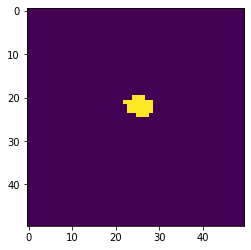

Time taken for epoch:  2770.6343972682953
Epoch = [  1/500]  Iter = [   0/ 796]  Loss = 0.1577 Avg Loss = 0.1577  Time = 3.5173s
Epoch = [  1/500]  Iter = [ 100/ 796]  Loss = 0.1653 Avg Loss = 0.1114  Time = 3.2352s
Epoch = [  1/500]  Iter = [ 200/ 796]  Loss = 0.1459 Avg Loss = 0.09311  Time = 3.0829s
Epoch = [  1/500]  Iter = [ 300/ 796]  Loss = 0.08399 Avg Loss = 0.08782  Time = 3.2331s
Epoch = [  1/500]  Iter = [ 400/ 796]  Loss = 0.04328 Avg Loss = 0.08397  Time = 3.2689s
Epoch = [  1/500]  Iter = [ 500/ 796]  Loss = 0.05686 Avg Loss = 0.0858  Time = 3.1120s
Epoch = [  1/500]  Iter = [ 600/ 796]  Loss = 0.1061 Avg Loss = 0.08677  Time = 3.4673s
Epoch = [  1/500]  Iter = [ 700/ 796]  Loss = 0.1007 Avg Loss = 0.08803  Time = 3.2005s
Dev_Loss 0.09677332750313329 Epoch 1
Epoch = [   1/ 500] TrainLoss = 0.08811  DevLoss = 0.09677 TrainTime = 2587.2760s DevTime = 58.5757s


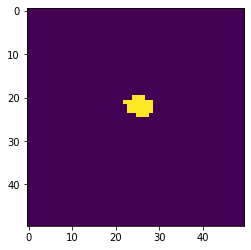

Time taken for epoch:  2723.0206072330475
Epoch = [  2/500]  Iter = [   0/ 796]  Loss = 0.1404 Avg Loss = 0.1404  Time = 3.2926s
Epoch = [  2/500]  Iter = [ 100/ 796]  Loss = 0.0868 Avg Loss = 0.1034  Time = 3.5000s
Epoch = [  2/500]  Iter = [ 200/ 796]  Loss = 0.121 Avg Loss = 0.0925  Time = 3.2471s
Epoch = [  2/500]  Iter = [ 300/ 796]  Loss = 0.1742 Avg Loss = 0.08876  Time = 3.2392s
Epoch = [  2/500]  Iter = [ 400/ 796]  Loss = 0.07669 Avg Loss = 0.08407  Time = 3.1834s
Epoch = [  2/500]  Iter = [ 500/ 796]  Loss = 0.1157 Avg Loss = 0.08586  Time = 3.0974s
Epoch = [  2/500]  Iter = [ 600/ 796]  Loss = 0.115 Avg Loss = 0.0884  Time = 3.2960s
Epoch = [  2/500]  Iter = [ 700/ 796]  Loss = 0.1732 Avg Loss = 0.0899  Time = 3.3926s
Dev_Loss 0.09677332750313329 Epoch 2
Epoch = [   2/ 500] TrainLoss = 0.0874  DevLoss = 0.09677 TrainTime = 2594.0414s DevTime = 65.0775s


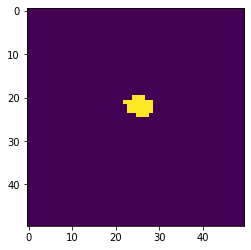

Time taken for epoch:  2740.695588350296
Epoch = [  3/500]  Iter = [   0/ 796]  Loss = 0.09685 Avg Loss = 0.09685  Time = 3.4496s
Epoch = [  3/500]  Iter = [ 100/ 796]  Loss = 0.08236 Avg Loss = 0.08837  Time = 3.1667s
Epoch = [  3/500]  Iter = [ 200/ 796]  Loss = 0.06918 Avg Loss = 0.08808  Time = 3.5051s
Epoch = [  3/500]  Iter = [ 300/ 796]  Loss = 0.05718 Avg Loss = 0.09144  Time = 3.2288s
Epoch = [  3/500]  Iter = [ 400/ 796]  Loss = 0.08981 Avg Loss = 0.08821  Time = 3.2686s
Epoch = [  3/500]  Iter = [ 500/ 796]  Loss = 0.117 Avg Loss = 0.08442  Time = 3.4375s
Epoch = [  3/500]  Iter = [ 600/ 796]  Loss = 0.1447 Avg Loss = 0.08354  Time = 3.2019s
Epoch = [  3/500]  Iter = [ 700/ 796]  Loss = 0.05097 Avg Loss = 0.08685  Time = 3.1171s
Dev_Loss 0.09677332750313329 Epoch 3
Epoch = [   3/ 500] TrainLoss = 0.08185  DevLoss = 0.09677 TrainTime = 2596.1606s DevTime = 65.2290s


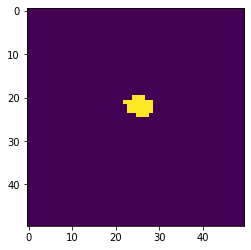

Time taken for epoch:  2738.317346572876
Epoch = [  4/500]  Iter = [   0/ 796]  Loss = 0.06069 Avg Loss = 0.06069  Time = 3.6040s
Epoch = [  4/500]  Iter = [ 100/ 796]  Loss = 0.1249 Avg Loss = 0.07537  Time = 3.3303s
Epoch = [  4/500]  Iter = [ 200/ 796]  Loss = 0.08814 Avg Loss = 0.08324  Time = 3.2302s
Epoch = [  4/500]  Iter = [ 300/ 796]  Loss = 0.1481 Avg Loss = 0.08467  Time = 3.4973s
Epoch = [  4/500]  Iter = [ 400/ 796]  Loss = 0.03277 Avg Loss = 0.0862  Time = 3.1934s
Epoch = [  4/500]  Iter = [ 500/ 796]  Loss = 0.05651 Avg Loss = 0.08611  Time = 3.2152s
Epoch = [  4/500]  Iter = [ 600/ 796]  Loss = 0.09945 Avg Loss = 0.08858  Time = 3.4840s
Epoch = [  4/500]  Iter = [ 700/ 796]  Loss = 0.09176 Avg Loss = 0.0865  Time = 3.2656s
Dev_Loss 0.09677332750313329 Epoch 4
Epoch = [   4/ 500] TrainLoss = 0.08456  DevLoss = 0.09677 TrainTime = 2617.3003s DevTime = 62.2030s


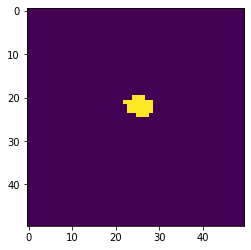

Time taken for epoch:  2756.053177833557
Epoch = [  5/500]  Iter = [   0/ 796]  Loss = 0.06566 Avg Loss = 0.06566  Time = 3.3255s
Epoch = [  5/500]  Iter = [ 100/ 796]  Loss = 0.09176 Avg Loss = 0.08095  Time = 3.2210s
Epoch = [  5/500]  Iter = [ 200/ 796]  Loss = 0.08635 Avg Loss = 0.08501  Time = 3.1960s
Epoch = [  5/500]  Iter = [ 300/ 796]  Loss = 0.04463 Avg Loss = 0.08862  Time = 3.2669s
Epoch = [  5/500]  Iter = [ 400/ 796]  Loss = 0.08471 Avg Loss = 0.08698  Time = 3.3457s
Epoch = [  5/500]  Iter = [ 500/ 796]  Loss = 0.02109 Avg Loss = 0.08148  Time = 3.2990s
Epoch = [  5/500]  Iter = [ 600/ 796]  Loss = 0.0799 Avg Loss = 0.07971  Time = 3.2248s
Epoch = [  5/500]  Iter = [ 700/ 796]  Loss = 0.07005 Avg Loss = 0.08936  Time = 3.5119s
Dev_Loss 0.09677332750313329 Epoch 5
Epoch = [   5/ 500] TrainLoss = 0.0876  DevLoss = 0.09677 TrainTime = 2629.4579s DevTime = 62.1292s


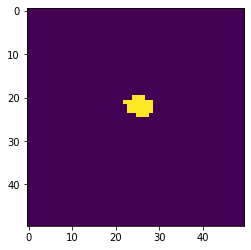

Time taken for epoch:  2766.033992767334
Epoch = [  6/500]  Iter = [   0/ 796]  Loss = 0.08273 Avg Loss = 0.08273  Time = 3.3271s
Epoch = [  6/500]  Iter = [ 100/ 796]  Loss = 0.125 Avg Loss = 0.08469  Time = 3.3211s
Epoch = [  6/500]  Iter = [ 200/ 796]  Loss = 0.04823 Avg Loss = 0.08344  Time = 3.5416s
Epoch = [  6/500]  Iter = [ 300/ 796]  Loss = 0.08737 Avg Loss = 0.08489  Time = 3.4803s
Epoch = [  6/500]  Iter = [ 400/ 796]  Loss = 0.06283 Avg Loss = 0.08549  Time = 3.3368s
Epoch = [  6/500]  Iter = [ 500/ 796]  Loss = 0.03471 Avg Loss = 0.08758  Time = 3.6773s
Epoch = [  6/500]  Iter = [ 600/ 796]  Loss = 0.1137 Avg Loss = 0.08866  Time = 3.3190s
Epoch = [  6/500]  Iter = [ 700/ 796]  Loss = 0.08525 Avg Loss = 0.08557  Time = 3.2844s
Dev_Loss 0.09677332750313329 Epoch 6
Epoch = [   6/ 500] TrainLoss = 0.08555  DevLoss = 0.09677 TrainTime = 2696.0519s DevTime = 66.5368s


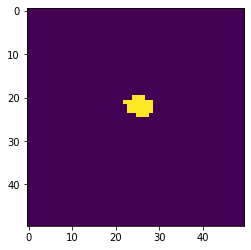

Time taken for epoch:  2838.618430376053
Epoch = [  7/500]  Iter = [   0/ 796]  Loss = 0.04866 Avg Loss = 0.04866  Time = 3.6212s
Epoch = [  7/500]  Iter = [ 100/ 796]  Loss = 0.07653 Avg Loss = 0.07098  Time = 3.3922s
Epoch = [  7/500]  Iter = [ 200/ 796]  Loss = 0.04456 Avg Loss = 0.07953  Time = 3.3846s
Epoch = [  7/500]  Iter = [ 300/ 796]  Loss = 0.06918 Avg Loss = 0.08555  Time = 3.4495s
Epoch = [  7/500]  Iter = [ 400/ 796]  Loss = 0.1385 Avg Loss = 0.08539  Time = 3.3370s
Epoch = [  7/500]  Iter = [ 500/ 796]  Loss = 0.1448 Avg Loss = 0.08582  Time = 3.2913s
Epoch = [  7/500]  Iter = [ 600/ 796]  Loss = 0.05619 Avg Loss = 0.08627  Time = 3.5695s
Epoch = [  7/500]  Iter = [ 700/ 796]  Loss = 0.1248 Avg Loss = 0.08771  Time = 3.4653s
Dev_Loss 0.09677332750313329 Epoch 7
Epoch = [   7/ 500] TrainLoss = 0.08383  DevLoss = 0.09677 TrainTime = 2747.4751s DevTime = 66.4009s


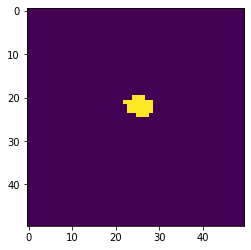

Time taken for epoch:  2893.705858230591
Epoch = [  8/500]  Iter = [   0/ 796]  Loss = 0.04053 Avg Loss = 0.04053  Time = 3.6683s
Epoch = [  8/500]  Iter = [ 100/ 796]  Loss = 0.1418 Avg Loss = 0.07394  Time = 3.3689s
Epoch = [  8/500]  Iter = [ 200/ 796]  Loss = 0.04477 Avg Loss = 0.07846  Time = 3.3969s
Epoch = [  8/500]  Iter = [ 300/ 796]  Loss = 0.04604 Avg Loss = 0.08147  Time = 3.6783s
Epoch = [  8/500]  Iter = [ 400/ 796]  Loss = 0.08441 Avg Loss = 0.08592  Time = 3.2395s
Epoch = [  8/500]  Iter = [ 500/ 796]  Loss = 0.09593 Avg Loss = 0.0831  Time = 3.3189s
Epoch = [  8/500]  Iter = [ 600/ 796]  Loss = 0.1016 Avg Loss = 0.08653  Time = 3.6718s
Epoch = [  8/500]  Iter = [ 700/ 796]  Loss = 0.06116 Avg Loss = 0.08748  Time = 3.3827s
Dev_Loss 0.09677332750313329 Epoch 8
Epoch = [   8/ 500] TrainLoss = 0.08732  DevLoss = 0.09677 TrainTime = 2706.7085s DevTime = 58.5169s


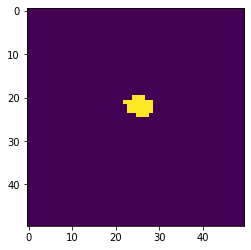

Time taken for epoch:  2838.3386170864105
Epoch = [  9/500]  Iter = [   0/ 796]  Loss = 0.06479 Avg Loss = 0.06479  Time = 3.3024s
Epoch = [  9/500]  Iter = [ 100/ 796]  Loss = 0.09105 Avg Loss = 0.07803  Time = 3.4281s
Epoch = [  9/500]  Iter = [ 200/ 796]  Loss = 0.0704 Avg Loss = 0.08384  Time = 3.3543s
Epoch = [  9/500]  Iter = [ 300/ 796]  Loss = 0.1206 Avg Loss = 0.08311  Time = 3.2581s
Epoch = [  9/500]  Iter = [ 400/ 796]  Loss = 0.0849 Avg Loss = 0.08636  Time = 3.4211s
Epoch = [  9/500]  Iter = [ 500/ 796]  Loss = 0.03407 Avg Loss = 0.09286  Time = 3.3122s
Epoch = [  9/500]  Iter = [ 600/ 796]  Loss = 0.06182 Avg Loss = 0.08252  Time = 3.2884s
Epoch = [  9/500]  Iter = [ 700/ 796]  Loss = 0.08825 Avg Loss = 0.08438  Time = 3.3664s
Dev_Loss 0.09677332750313329 Epoch 9
Epoch = [   9/ 500] TrainLoss = 0.08502  DevLoss = 0.09677 TrainTime = 2693.0238s DevTime = 59.3351s


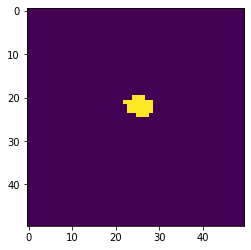

Time taken for epoch:  2832.598766565323
Epoch = [ 10/500]  Iter = [   0/ 796]  Loss = 0.135 Avg Loss = 0.135  Time = 3.4555s
Epoch = [ 10/500]  Iter = [ 100/ 796]  Loss = 0.08007 Avg Loss = 0.1017  Time = 3.5207s
Epoch = [ 10/500]  Iter = [ 200/ 796]  Loss = 0.06481 Avg Loss = 0.08868  Time = 3.5114s
Epoch = [ 10/500]  Iter = [ 300/ 796]  Loss = 0.05707 Avg Loss = 0.08576  Time = 3.4675s
Epoch = [ 10/500]  Iter = [ 400/ 796]  Loss = 0.05686 Avg Loss = 0.08928  Time = 3.6175s
Epoch = [ 10/500]  Iter = [ 500/ 796]  Loss = 0.09302 Avg Loss = 0.08544  Time = 3.3875s
Epoch = [ 10/500]  Iter = [ 600/ 796]  Loss = 0.08776 Avg Loss = 0.08771  Time = 3.3277s
Epoch = [ 10/500]  Iter = [ 700/ 796]  Loss = 0.07701 Avg Loss = 0.08486  Time = 3.4789s
Dev_Loss 0.09677332750313329 Epoch 10
Epoch = [  10/ 500] TrainLoss = 0.09014  DevLoss = 0.09677 TrainTime = 2733.7767s DevTime = 59.8328s


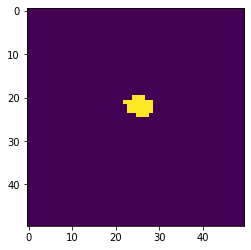

Time taken for epoch:  2869.87158203125
Epoch = [ 11/500]  Iter = [   0/ 796]  Loss = 0.07017 Avg Loss = 0.07017  Time = 3.5414s
Epoch = [ 11/500]  Iter = [ 100/ 796]  Loss = 0.06672 Avg Loss = 0.07854  Time = 3.3454s
Epoch = [ 11/500]  Iter = [ 200/ 796]  Loss = 0.07907 Avg Loss = 0.08804  Time = 3.5489s
Epoch = [ 11/500]  Iter = [ 300/ 796]  Loss = 0.03014 Avg Loss = 0.08384  Time = 3.3440s
Epoch = [ 11/500]  Iter = [ 400/ 796]  Loss = 0.0815 Avg Loss = 0.08334  Time = 3.2950s
Epoch = [ 11/500]  Iter = [ 500/ 796]  Loss = 0.07355 Avg Loss = 0.08847  Time = 3.7718s
Epoch = [ 11/500]  Iter = [ 600/ 796]  Loss = 0.141 Avg Loss = 0.0846  Time = 3.3237s
Epoch = [ 11/500]  Iter = [ 700/ 796]  Loss = 0.0549 Avg Loss = 0.08817  Time = 3.2951s
Dev_Loss 0.09677332750313329 Epoch 11
Epoch = [  11/ 500] TrainLoss = 0.08336  DevLoss = 0.09677 TrainTime = 2724.9793s DevTime = 66.0606s


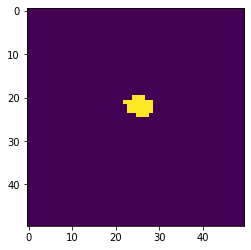

Time taken for epoch:  2867.76997923851
Epoch = [ 12/500]  Iter = [   0/ 796]  Loss = 0.02281 Avg Loss = 0.02281  Time = 3.5114s
Epoch = [ 12/500]  Iter = [ 100/ 796]  Loss = 0.1299 Avg Loss = 0.0619  Time = 3.3427s
Epoch = [ 12/500]  Iter = [ 200/ 796]  Loss = 0.1009 Avg Loss = 0.07538  Time = 3.2883s
Epoch = [ 12/500]  Iter = [ 300/ 796]  Loss = 0.1492 Avg Loss = 0.07982  Time = 3.4166s
Epoch = [ 12/500]  Iter = [ 400/ 796]  Loss = 0.05231 Avg Loss = 0.08287  Time = 3.2744s
Epoch = [ 12/500]  Iter = [ 500/ 796]  Loss = 0.09508 Avg Loss = 0.08691  Time = 3.1775s
Epoch = [ 12/500]  Iter = [ 600/ 796]  Loss = 0.09123 Avg Loss = 0.08667  Time = 3.3654s
Epoch = [ 12/500]  Iter = [ 700/ 796]  Loss = 0.0911 Avg Loss = 0.08508  Time = 3.3950s
Dev_Loss 0.09677332750313329 Epoch 12
Epoch = [  12/ 500] TrainLoss = 0.08903  DevLoss = 0.09677 TrainTime = 2685.7944s DevTime = 55.8567s


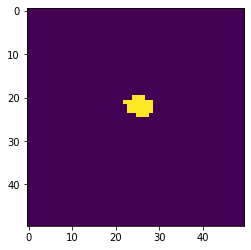

Time taken for epoch:  2820.893129825592
Epoch = [ 13/500]  Iter = [   0/ 796]  Loss = 0.1653 Avg Loss = 0.1653  Time = 3.4381s
Epoch = [ 13/500]  Iter = [ 100/ 796]  Loss = 0.08463 Avg Loss = 0.1147  Time = 3.4630s
Epoch = [ 13/500]  Iter = [ 200/ 796]  Loss = 0.05818 Avg Loss = 0.09446  Time = 3.4400s
Epoch = [ 13/500]  Iter = [ 300/ 796]  Loss = 0.04564 Avg Loss = 0.09158  Time = 3.6500s
Epoch = [ 13/500]  Iter = [ 400/ 796]  Loss = 0.1742 Avg Loss = 0.08919  Time = 3.4140s
Epoch = [ 13/500]  Iter = [ 500/ 796]  Loss = 0.09258 Avg Loss = 0.08918  Time = 3.3589s
Epoch = [ 13/500]  Iter = [ 600/ 796]  Loss = 0.102 Avg Loss = 0.08452  Time = 3.6401s
Epoch = [ 13/500]  Iter = [ 700/ 796]  Loss = 0.08616 Avg Loss = 0.08226  Time = 3.3401s
Dev_Loss 0.09677332750313329 Epoch 13
Epoch = [  13/ 500] TrainLoss = 0.08506  DevLoss = 0.09677 TrainTime = 2752.7613s DevTime = 56.6194s


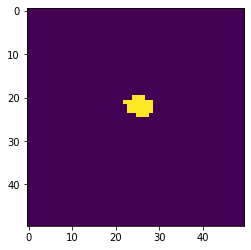

Time taken for epoch:  2886.7876839637756
Epoch = [ 14/500]  Iter = [   0/ 796]  Loss = 0.0865 Avg Loss = 0.0865  Time = 3.4903s
Epoch = [ 14/500]  Iter = [ 100/ 796]  Loss = 0.08344 Avg Loss = 0.08677  Time = 3.6869s
Epoch = [ 14/500]  Iter = [ 200/ 796]  Loss = 0.043 Avg Loss = 0.0851  Time = 3.5395s
Epoch = [ 14/500]  Iter = [ 300/ 796]  Loss = 0.07748 Avg Loss = 0.08761  Time = 3.4160s
Epoch = [ 14/500]  Iter = [ 400/ 796]  Loss = 0.02355 Avg Loss = 0.08451  Time = 3.6794s
Epoch = [ 14/500]  Iter = [ 500/ 796]  Loss = 0.121 Avg Loss = 0.08807  Time = 3.3802s
Epoch = [ 14/500]  Iter = [ 600/ 796]  Loss = 0.07069 Avg Loss = 0.08388  Time = 3.3632s
Epoch = [ 14/500]  Iter = [ 700/ 796]  Loss = 0.07936 Avg Loss = 0.08487  Time = 3.5793s
Dev_Loss 0.09677332750313329 Epoch 14
Epoch = [  14/ 500] TrainLoss = 0.0913  DevLoss = 0.09677 TrainTime = 2745.9209s DevTime = 55.2483s


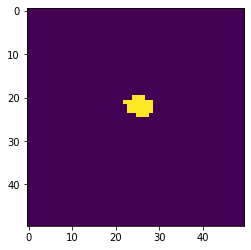

Time taken for epoch:  2878.2638528347015
Epoch = [ 15/500]  Iter = [   0/ 796]  Loss = 0.07936 Avg Loss = 0.07936  Time = 3.3794s
Epoch = [ 15/500]  Iter = [ 100/ 796]  Loss = 0.04369 Avg Loss = 0.09105  Time = 3.3466s
Epoch = [ 15/500]  Iter = [ 200/ 796]  Loss = 0.05068 Avg Loss = 0.0848  Time = 3.3547s
Epoch = [ 15/500]  Iter = [ 300/ 796]  Loss = 0.03145 Avg Loss = 0.08336  Time = 3.3070s
Epoch = [ 15/500]  Iter = [ 400/ 796]  Loss = 0.06479 Avg Loss = 0.08413  Time = 3.4338s
Epoch = [ 15/500]  Iter = [ 500/ 796]  Loss = 0.1198 Avg Loss = 0.08432  Time = 3.3573s
Epoch = [ 15/500]  Iter = [ 600/ 796]  Loss = 0.05214 Avg Loss = 0.08593  Time = 3.2852s
Epoch = [ 15/500]  Iter = [ 700/ 796]  Loss = 0.03706 Avg Loss = 0.08673  Time = 3.4192s
Dev_Loss 0.09677332750313329 Epoch 15
Epoch = [  15/ 500] TrainLoss = 0.08332  DevLoss = 0.09677 TrainTime = 2738.6939s DevTime = 58.8528s


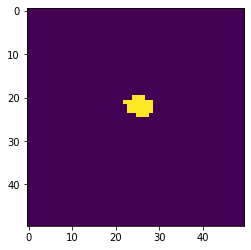

Time taken for epoch:  2872.1191029548645
Epoch = [ 16/500]  Iter = [   0/ 796]  Loss = 0.07069 Avg Loss = 0.07069  Time = 3.3743s
Epoch = [ 16/500]  Iter = [ 100/ 796]  Loss = 0.1362 Avg Loss = 0.08647  Time = 3.3975s
Epoch = [ 16/500]  Iter = [ 200/ 796]  Loss = 0.08696 Avg Loss = 0.08663  Time = 3.5336s
Epoch = [ 16/500]  Iter = [ 300/ 796]  Loss = 0.07826 Avg Loss = 0.08311  Time = 3.4529s
Epoch = [ 16/500]  Iter = [ 400/ 796]  Loss = 0.05651 Avg Loss = 0.08191  Time = 3.4427s
Epoch = [ 16/500]  Iter = [ 500/ 796]  Loss = 0.09084 Avg Loss = 0.08633  Time = 3.7285s
Epoch = [ 16/500]  Iter = [ 600/ 796]  Loss = 0.09323 Avg Loss = 0.08605  Time = 3.4113s
Epoch = [ 16/500]  Iter = [ 700/ 796]  Loss = 0.04619 Avg Loss = 0.08733  Time = 3.3135s
Dev_Loss 0.09677332750313329 Epoch 16
Epoch = [  16/ 500] TrainLoss = 0.08337  DevLoss = 0.09677 TrainTime = 2754.6517s DevTime = 65.1508s


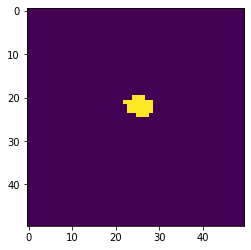

Time taken for epoch:  2900.047958135605
Epoch = [ 17/500]  Iter = [   0/ 796]  Loss = 0.03915 Avg Loss = 0.03915  Time = 3.5641s
Epoch = [ 17/500]  Iter = [ 100/ 796]  Loss = 0.08402 Avg Loss = 0.06541  Time = 3.3750s
Epoch = [ 17/500]  Iter = [ 200/ 796]  Loss = 0.1275 Avg Loss = 0.08001  Time = 3.3025s
Epoch = [ 17/500]  Iter = [ 300/ 796]  Loss = 0.1157 Avg Loss = 0.08349  Time = 3.4544s
Epoch = [ 17/500]  Iter = [ 400/ 796]  Loss = 0.1561 Avg Loss = 0.08758  Time = 3.4411s
Epoch = [ 17/500]  Iter = [ 500/ 796]  Loss = 0.07952 Avg Loss = 0.08773  Time = 3.4368s
Epoch = [ 17/500]  Iter = [ 600/ 796]  Loss = 0.08665 Avg Loss = 0.08468  Time = 3.5319s


In [ ]:
def train(args): 
    args.exp_dir.mkdir(parents=True, exist_ok=True)
    writer = SummaryWriter(logdir=str(args.logdir)) #log directory for run

    if args.resume: #be aware of the option
        checkpoint, model, optimizer = load_model(args.checkpoint,args)
        args = checkpoint['args']
        best_dev_loss = checkpoint['best_dev_loss']
        #start_epoch = checkpoint['epoch']
        start_epoch = 0
        del checkpoint
    else:
        model = build_model(args)
        optimizer = build_optim(args, model.parameters())
        best_dev_loss = 1e9
        start_epoch = 0
    logging.info(args)
    logging.info(model)

    #train_loader,dev_loader,test_loader = create_data_loaders()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, args.lr_step_size, args.lr_gamma)
    optimizer.step()

    for epoch in range(start_epoch, args.num_epochs):
        t=time.time()
        scheduler.step(epoch)
        train_loss, train_time = train_epoch(args, epoch, model, train_loader, optimizer, writer)
        dev_loss, dev_time = evaluate(args, epoch, model, dev_loader, writer)
        #visualize(args, epoch, model, train_loader, writer)

        is_new_best = dev_loss < best_dev_loss
        best_dev_loss = min(best_dev_loss, dev_loss)
        save_model(args, args.exp_dir, epoch, model, optimizer, best_dev_loss, is_new_best)
        print(f'Epoch = [{epoch:4d}/{args.num_epochs:4d}] TrainLoss = {train_loss:.4g} ',
        f'DevLoss = {dev_loss:.4g} TrainTime = {train_time:.4f}s DevTime = {dev_time:.4f}s')
        
        for iter, data in enumerate(train_loader):
            kspace, full = data
            input = kspace.unsqueeze(1)#.to(f'{args.device}:{model.device_ids[0]}')
            target = full#.to(f'{args.device}:{model.device_ids[0]}')
            output = model(input).squeeze(1)
            image=output.to('cpu').squeeze(1).detach()#.numpy()
            plt.imshow(image.reshape(50,50))
            plt.show()
            break;
        
        logging.info(
            f'Epoch = [{epoch:4d}/{args.num_epochs:4d}] TrainLoss = {train_loss:.4g} '
            f'DevLoss = {dev_loss:.4g} TrainTime = {train_time:.4f}s DevTime = {dev_time:.4f}s',
        )
        print("Time taken for epoch: ",time.time()-t)
    writer.close()
    
train(args)